In [16]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import sklearn
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from wordcloud import WordCloud
from konlpy.tag import Okt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from wordcloud import WordCloud
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.rcParams['axes.unicode_minus'] = False

## 전처리

In [34]:
# yc = pd.read_csv('comment.csv')
# yc = yc[:1000000]
# yc = yc.sample(frac = 0.0002)
# yc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 893316 to 399699
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   200 non-null    int64 
 1   Comment      200 non-null    object
 2   Author       200 non-null    object
 3   PublishedAt  200 non-null    object
 4   LikeCount    200 non-null    int64 
 5   id           200 non-null    int64 
 6   유튜버          200 non-null    object
 7   제목           200 non-null    object
 8   유료광고유무       200 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 15.6+ KB


In [38]:
# yc_new = pd.read_csv('itsub_yooksik_comments.csv')
# yc_new = yc_new.sample(frac = 0.0005)
# yc = pd.concat([yc, yc_new], axis = 0)
# yc = yc[['Comment','제목','유튜버']]
# yc.to_csv('youtuber_comment.csv', encoding='utf-8-sig')

In [40]:
# 댓글 길이
yc = pd.read_csv('youtuber_comment.csv')
yc['Comment'] = yc['Comment'].astype(str)
comment_lengths = yc['Comment'].apply(len)
average_length = comment_lengths.mean()
print("댓글 길이:", average_length)

댓글 길이: 52.213872832369944


In [41]:
yc['Comment'] = yc['Comment'].str.slice(0,50)

In [42]:
# 한글 불용어 리스트 정의
stop_words = ["은", "는", "이", "가", "을", "를", "에", "와", "과"]
def remove_stopwords(text):
    # tag 제거
    text = re.sub('<[^>]*>', ' ', text)
    # 표현 제거
    text = re.sub('ㅋ{2,}|ㅠ{2,}', ' ', text)
    # 불용어 제거
    for word in stop_words:
        text = re.sub(' '+word+' ', ' ', text)
    # 특수 문자 제거
    text = re.sub('[^\w\s]', '', text)
    return text

yc['Comment'] = yc['Comment'].apply(remove_stopwords)

In [43]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator").to("cpu")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [44]:
def sentiment_analysis(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True, max_length=30).to("cpu")
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1)
    return probabilities[0][1].item()

In [49]:
yc.tail()

,Unnamed: 0,Comment,제목,유튜버,comment_analysis,comment_analysis_score
341,51922,아이고 프로콘을 괜히 샀네,단통법 10년만에 폐지 각.. 국민 85%가 반대했던 희대의 악법이 과연 바뀔까?,ITSub잇섭,0.505690,0.364796
342,79336,이미 프로콘은 있지만 뽐뿌오네요,"카오카무 : ""SSS급 야들야들"" 백종원이 강추한 태국 족발! (feat. NCT ...",육식맨 YOOXICMAN,0.501439,0.299073
343,236960,작년에 휘센이동식 에어컨 고민만 하다가 재고 없어서 못샀는데 영상보면서 지금 바로 ...,주호민 작가님과 고기동에서 고기동부리 먹기 : 로스트비프동 일본 가정식 근본 레시피,육식맨 YOOXICMAN,0.512721,0.473491
344,55751,LG랑 파센느 중에서 고민하는 사람이 많을 것 같은데 그 두개를 비교해주는 영상을 ...,단통법 10년만에 폐지 각.. 국민 85%가 반대했던 희대의 악법이 과연 바뀔까?,ITSub잇섭,0.496821,0.227663
345,63474,애플이 어떻게 망할지 궁금했는데 살살 보이기 시작하는 거 같은데,SSD값 대폭락장에 나타난 신인.. SK하이닉스 신제품 X31 외장 SSD 써봤습니다.,ITSub잇섭,0.487802,0.088225


In [45]:
yc['comment_analysis'] = yc['Comment'].apply(sentiment_analysis)

In [46]:
mm = MinMaxScaler()
yc['comment_analysis_score'] = mm.fit_transform(yc[['comment_analysis']])

In [248]:
yc['comment_analysis_score'] = yc['comment_analysis_score']*5

In [252]:
com = yc.groupby('유튜버')['comment_analysis_score'].mean().reset_index()

In [47]:
# 유튜버 이름 넣으면 word cloud 보여줌
def wc_plot(name):
    s = yc.loc[yc['유튜버'] == name]
    okt = Okt()
    nouns = okt.nouns(' '.join(s['Comment']))
    adjectives = okt.pos(' '.join(s['Comment']), stem=True)
    adjectives = [word for word, pos in adjectives if pos == 'Adjective']
    words = nouns + adjectives

    wordcloud = WordCloud(font_path = 'C:/Users/teddy/Desktop/NanumGothic.ttf', width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(words))
    plt.figure(figsize=(12, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

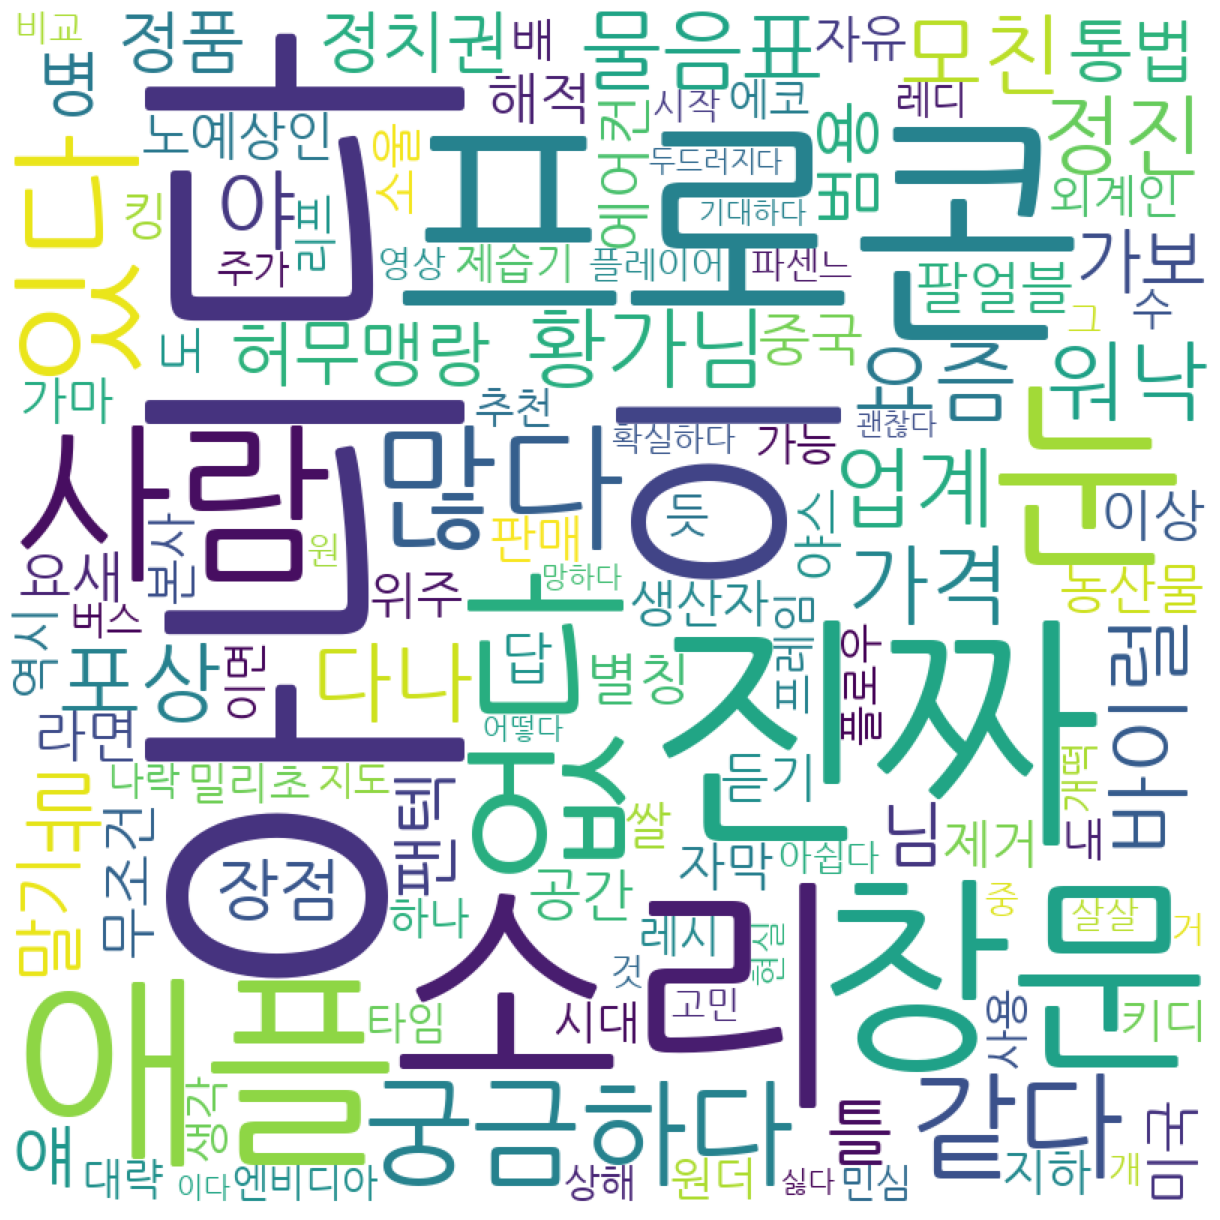

In [51]:
wc_plot('ITSub잇섭')

In [59]:
# def corr(words):
#     df = pd.read_csv('youtuber_model.csv')
#     def preprocessing(word):
#         word = word.replace(' ', '')
#         word = word.split('#')
#         word = ' '.join([str(words) for words in word])
#         return word
#     df['word_analysis'] = (df['더보기란']).astype(str).apply(preprocessing)
#     df['word_analysis'] = df['word_analysis'].dropna()
#     for ss in words:
#         s = []
#         inputs = tokenizer(ss, return_tensors="pt", padding=True, truncation=True, max_length=50).to("cpu")
#         outputs = tokenizer(df['word_analysis'], return_tensors="pt", padding=True, truncation=True, max_length=50).to("cpu")
#         vector_inputs = inputs['input_ids'].numpy().flatten()
#         vector_outputs = outputs['input_ids'].numpy().flatten()
#         max_length = max(len(vector_inputs), len(vector_outputs))
#         vector_inputs = np.pad(vector_inputs, (0, max_length - len(vector_inputs)))
#         vector_outputs = np.pad(vector_outputs, (0, max_length - len(vector_outputs)))
#         print(vector_inputs)
#         print(vector_outputs)
#         # 벡터 간의 코사인 유사도 계산
#         similarity = cosine_similarity([vector_inputs], [vector_outputs])[0][0]
#         s.append(similarity)
#     df['similarity'] = s

In [188]:
df = pd.read_pickle('df.pkl')
def preprocessing(word):
    word = word.replace(' ', '')
    word = word.split('#')
    word = ' '.join([str(words) for words in word])
    return word
df['word_analysis'] = (df['더보기란']).astype(str).apply(preprocessing)
df['word_analysis'] = df['word_analysis'].dropna()
def token(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True, max_length=50).to("cpu")
    vector_inputs = inputs['input_ids'].numpy().flatten()
    vector_inputs = np.pad(vector_inputs, (0, 50 - len(vector_inputs)))
    return vector_inputs
df['output'] = df['word_analysis'].apply(token)

In [189]:
s = []
for word in words:
    s.append(token(word))
df['input'] = [s]*len(df)
inputs = df['input'].tolist()
outputs = df['output'].tolist()


In [199]:
inputs

[[array([   2,   87, 4079,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
  array([ 2, 92,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
  array([   2,   69, 4012,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0])],
 [array([   2,   87, 4079,    3,    0,    0,    0,    0,    0,    0,    0,
 

In [190]:
def cos_similar(inputs):
    # 코사인 유사도 계산 및 합 계산
    answers = []
    for i in range(len(outputs)):
        cosine_totals = []
        output_vec = outputs[i]
        for j in range(len(inputs[0])):
            input_vec = inputs[i][j]
            # print(input_vec)
            # print(output_vec)
            similarity = cosine_similarity([input_vec], [output_vec])[0][0]
            cosine_totals.append(similarity)
        ans = np.mean(cosine_totals)
        answers.append(ans)
    return answers 

In [191]:
df['word_corr'] = cos_similar(inputs)

In [198]:
df

,id,카테고리,검색어,유튜버,비교구독자수,구독자수,유튜버정보,제목,조회수,좋아요,...,view_count,subscriber_count,upload_time,date_difference,like_count_mean,budget,word_analysis,output,input,word_corr
0,2,['LIFE'],유소나,유소나,632000,구독자 64만명,💙광고문의 usona_official@naver.com💙,예쁜게 죄,"조회수 203,721회","나 외에 사용자 2,345명이 이 동영상을 좋아함",...,203721,632000,2023-05-20,19,1798.0,4000,유소나 토크💟광고문의usona_official@naver.com💟인스타@usona...,"[2, 3221, 4104, 4065, 1, 67, 24139, 6743, 1227...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.068024
1,2,['LIFE'],유소나,유소나,632000,구독자 64만명,💙광고문의 usona_official@naver.com💙,피파천재 유소나,"조회수 55,040회",나 외에 사용자 705명이 이 동영상을 좋아함,...,55040,632000,2023-05-17,22,1798.0,4000,유소나 피파4 레알마드리드💟광고문의usona_official@naver.com💟인...,"[2, 3221, 4104, 4065, 28541, 4204, 1, 67, 2413...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.060753
2,2,['LIFE'],유소나,유소나,632000,구독자 64만명,💙광고문의 usona_official@naver.com💙,카드깡을 맛본 부자 누나,"조회수 211,664회","나 외에 사용자 1,829명이 이 동영상을 좋아함",...,211664,632000,2023-05-15,24,1798.0,4000,유소나 피파4 두치와뿌꾸💟광고문의usona_official@naver.com💟인스...,"[2, 3221, 4104, 4065, 28541, 4204, 1, 67, 2413...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.060753
3,2,['LIFE'],유소나,유소나,632000,구독자 64만명,💙광고문의 usona_official@naver.com💙,수면마취 덜 깬 소나ㅋㅋㅋㅋㅋ,"조회수 124,988회","나 외에 사용자 1,180명이 이 동영상을 좋아함",...,124988,632000,2023-05-12,27,1798.0,4000,유소나 수면마취 토크💟광고문의usona_official@naver.com💟인스타@...,"[2, 3221, 4104, 4065, 10388, 4177, 4470, 1, 67...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.066565
4,2,['LIFE'],유소나,유소나,632000,구독자 64만명,💙광고문의 usona_official@naver.com💙,나도 가끔 이런거 입는다,"조회수 287,425회","나 외에 사용자 2,931명이 이 동영상을 좋아함",...,287425,632000,2023-05-10,29,1798.0,4000,유소나 하정우 블루워터💙유소나X블루워터콜라보기념단기특별할인💙:https://rb....,"[2, 3221, 4104, 4065, 30090, 4180, 8870, 4599,...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.068218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,2000,['CAR'],재호Fitness,재호 - Fitness,230000,구독자 25.6만명,안녕하세요 거제도에 살고 있는 트레이너이자 물리치료사 노재호입니다.\n\n건강하고 ...,7 MIN SIXPACK ABS WORKOUT AT HOME (No Equipmen...,"조회수 7,567회",나 외에 사용자 530명이 이 동영상을 좋아함,...,7567,230000,2023-05-21,18,1012.0,3000,"Hello,IamJaeho,atrainerandphysicaltherapist.To...","[2, 19831, 18268, 4008, 16, 45, 7095, 4624, 16...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.171400
8718,2000,['CAR'],재호Fitness,재호 - Fitness,230000,구독자 25.6만명,안녕하세요 거제도에 살고 있는 트레이너이자 물리치료사 노재호입니다.\n\n건강하고 ...,15 MIN FULL BODY WORKOUT AT HOME (Fat burn | N...,"조회수 13,827회",나 외에 사용자 814명이 이 동영상을 좋아함,...,13827,230000,2023-05-14,25,1012.0,3000,"Hello,IamJaeho,atrainerandphysicaltherapist.To...","[2, 19831, 18268, 4008, 16, 45, 7095, 4624, 16...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.155366
8719,2000,['CAR'],재호Fitness,재호 - Fitness,230000,구독자 25.6만명,안녕하세요 거제도에 살고 있는 트레이너이자 물리치료사 노재호입니다.\n\n건강하고 ...,7 MIN SIX PACK ABS WORKOUT AT HOME | Beginner ...,"조회수 42,766회","나 외에 사용자 1,983명이 이 동영상을 좋아함",...,42766,230000,2023-05-07,32,1012.0,3000,"Hello,thisisJaeho,atrainerandphysicaltherapist...","[2, 19831, 18268, 4008, 16, 29030, 7057, 4624,...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.159363
8720,2000,['CAR'],재호Fitness,재호 - Fitness,230000,구독자 25.6만명,안녕하세요 거제도에 살고 있는 트레이너이자 물리치료사 노재호입니다.\n\n건강하고 ...,"CHEST, SHOULDER & ABS WORKOUT at Home (6 Pack ...","조회수 12,736회",나 외에 사용자 666명이 이 동영상을 좋아함,...,12736,230000,2023-04-30,39,1012.0,3000,"Hello,IamJaeho,atrainerandphysicaltherapist.To...","[2, 19831, 18268, 4008, 16, 45, 7095, 4624, 16...","[[2, 87, 4079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.169263


In [192]:
df.groupby('유튜버')['word_corr'].mean().reset_index()

,유튜버,word_corr
0,#Like_Football 라이크풋볼,0.334493
1,-별별샘 무지개교실 BB origami,0.068459
2,1분 동물짤,0.274953
3,20th Century Studios Korea,0.119451
4,"3040재테크, 세빛희",0.049426
...,...,...
1633,희준,0.148842
1634,흰수염고래스포츠,0.287924
1635,히코,0.062002
1636,힐링보이 Healingboy,0.079425


In [237]:
class cos():
    def __init__(self, data, inputs):
        self.data = pd.read_pickle(data)
        self.inputs = inputs
        self.pre()
        
    def cos_similar(self):
        answers = []
        outputs = self.data['outputs'].to_list()
        inputs = self.data['inputs'].to_list()
        for i in range(len(outputs)):
            cosine_totals = []
            output_vec = outputs[i]
            for j in range(len(inputs[0])):
                input_vec = inputs[i][j]
                # print(input_vec)
                # print(output_vec)
                similarity = cosine_similarity([input_vec], [output_vec])[0][0]
                cosine_totals.append(similarity)
            ans = np.mean(cosine_totals)
            answers.append(ans)
        return answers
    
        inputs = df['input'].tolist()
        outputs = df['output'].tolist()
    
    def token(self, comment):
        inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True, max_length=50).to("cpu")
        vector_inputs = inputs['input_ids'].numpy().flatten()
        vector_inputs = np.pad(vector_inputs, (0, 50 - len(vector_inputs)))
        return vector_inputs

    def preprocessing(self, word):
        word = word.replace(' ', '')
        word = word.split('#')
        word = ' '.join([str(words) for words in word])
        return word
    
    def pre(self):
        df = self.data
        df['word_analysis'] = (df['더보기란']).astype(str).apply(self.preprocessing)
        df['word_analysis'] = df['word_analysis'].dropna()
        df['outputs'] = df['word_analysis'].apply(self.token)
        s = []
        for word in self.inputs:
            s.append(self.token(word))
        df['inputs'] = [s]*len(df)
        self.data = df
        
    def ret(self):
        self.data['word_corr'] = self.cos_similar()
        ret_df = self.data.groupby('유튜버')['word_corr'].mean().reset_index()
        return ret_df

In [238]:
inputs=["치킨", "통닭", "피자"]

In [239]:
o = cos('df.pkl', inputs)

In [241]:
ret = o.ret()

In [244]:
ret[['유튜버']].to_pickle("youtubers.pkl")

In [246]:
t = pd.read_pickle("youtubers.pkl")

In [254]:
t

,유튜버
0,#Like_Football 라이크풋볼
1,-별별샘 무지개교실 BB origami
2,1분 동물짤
3,20th Century Studios Korea
4,"3040재테크, 세빛희"
...,...
1633,희준
1634,흰수염고래스포츠
1635,히코
1636,힐링보이 Healingboy


In [257]:
merged_df = pd.merge(t,com, how = 'left')

In [258]:
merged_df

,유튜버,comment_analysis_score
0,#Like_Football 라이크풋볼,NaN
1,-별별샘 무지개교실 BB origami,NaN
2,1분 동물짤,NaN
3,20th Century Studios Korea,NaN
4,"3040재테크, 세빛희",NaN
...,...,...
1633,희준,NaN
1634,흰수염고래스포츠,NaN
1635,히코,NaN
1636,힐링보이 Healingboy,NaN


In [267]:
random_values = np.random.random(size=merged_df['comment_analysis_score'].isnull().sum())
merged_df.loc[merged_df['comment_analysis_score'].isnull(), 'comment_analysis_score'] = random_values
merged_df

,유튜버,comment_analysis_score
0,#Like_Football 라이크풋볼,0.502923
1,-별별샘 무지개교실 BB origami,0.730501
2,1분 동물짤,0.511696
3,20th Century Studios Korea,0.215102
4,"3040재테크, 세빛희",0.565414
...,...,...
1633,희준,0.386461
1634,흰수염고래스포츠,0.662786
1635,히코,0.892493
1636,힐링보이 Healingboy,0.888856


In [268]:
merged_df.to_pickle('comment.pkl')